In [1]:
%pylab inline
from pathlib import Path
import sys
path_to_script =  Path("~/projects/scaffan/").expanduser()
sys.path.insert(0,str(path_to_script))
import scaffan
import io3d # just to get data
import scaffan.image as scim
from typing import List

Populating the interactive namespace from numpy and matplotlib
add path C:\Users\Jirik\Downloads\openslide-win64-20171122\bin


In [3]:
from pathlib import Path
import sklearn.cluster
import sklearn.naive_bayes
import sklearn.svm
from scaffan.image import View
from sklearn.externals import joblib
from scipy.ndimage import gaussian_filter
import skimage


import skimage.filters
from skimage.morphology import disk

class SlideSegmentation():
    def __init__(self):
        self.anim = None
        self.pixelsize_mm = [0.01, 0.01]
        self.tile_size = [256, 256]
        self.level = None
        self.tiles:List["View"] = None
        self.clf = sklearn.svm.SVC(gamma='scale')
        self.clf_fn = "standard_svm_model.pkl"
        self.clf = joblib.load(self.clf_fn)
        self.predicted_tiles = None
        self.output_label_fn = "label.png"
        self.output_raster_fn = "image.png"
        self.devel_imcrop = None
#         self.devel_imcrop = np.array([20000, 15000])
        self.full_output_image = None
        self.full_raster_image = None
        
        pass
    
    def init(self, fn:Path):
        self.anim = scim.AnnotatedImage(fn)
        self.level = self._find_best_level()
        self.tiles = None
#         self.predicted_tiles = None
        self.make_tiles()
        
    def train_svm_classifier(self, pixels=None, y=None):
        if pixels is None:
            pixels, y =self.prepare_training_pixels()
            
        self.clf.fit(pixels, y=y)
        
    def save_classifier(self):
        joblib.dump(self.clf, 'standard_svm_model.pkl') 
        

    def prepare_training_pixels(self):
        """
        Use annotated image to train classifier.
        Red area is extra-lobular tissue.
        Black area is intra-lobular tissue.
        Magenta area is empty part of the image.
        """
        pixels0 = self._get_pixels("#FF00FF") # empty
        pixels1 = self._get_pixels("#000000") # black
        pixels2 = self._get_pixels("#FF0000") # extra lobula
        labels0 = ones([pixels0.shape[0]]) * 0
        labels1 = ones([pixels1.shape[0]]) * 1
        labels2 = ones([pixels2.shape[0]]) * 2
        pixels = np.concatenate([pixels0, pixels1, pixels2])
        y = np.concatenate([labels0, labels1, labels2])
        
        return pixels, y
    
    def _get_pixels(self, color:str):
        """
        Use outer annotation with defined color and removed holes to 
        extract features in pixels.
        """
        outer_ids, holes_ids = self.anim.select_just_outer_annotations(color)
        views = self.anim.get_views(outer_ids, level=self.level)
        pixels_list = []
        for id1, id2, view_ann in zip(outer_ids, holes_ids, views):
            ann_raster = view_ann.get_annotation_raster(id1, holes_ids=id2)
    #     ann_raster1 = view_ann.get_annotation_region_raster(id1)
    #     if len(id2) == 0:
    #         ann_raster = ann_raster1
    #     else:
    #         ann_raster2 = view_ann.get_annotation_region_raster(id2[0])
    #         ann_raster = ann_raster1 ^ ann_raster2

#             plt.figure()
#             plt.imshow(ann_raster)
#             plt.show()
            img = self._get_features(view_ann)
            pixels = img[ann_raster]
            pixels_list.append(pixels)
        pixels_all = np.concatenate(pixels_list, axis=0)
        return pixels_all
        
#     def _get_pixels(self, anim, color, n):
#         ann_ids = anim.select_annotations_by_color(color)
#         view = anim.get_views(ann_ids, level=self.level)[n]
#         img_ann = view.get_annotation_region_raster(ann_ids[n])

#         img = self._get_features(view)
#         pixels = img[img_ann]

#         return pixels, view
    
    def _get_features(self, view:View):
        """
        Three colors and one gaussian smooth reg channel.
        
        img_sob: gaussian blure applied on gradient sobel operator give information about texture richness in neighborhood
        
        """
        img = view.get_region_image(as_gray=False)
        img_gauss2 = gaussian_filter(img[:,:,0], 2)
        img_gauss5 = gaussian_filter(img[:,:,0], 5)
        
        img = np.copy(img)
        imgout = np.zeros([img.shape[0], img.shape[1], 8])
        img_sob = skimage.filters.sobel(img[:,:,0]/255)
        img_sob_gauss2 = gaussian_filter(img_sob, 2)
        img_sob_gauss5 = gaussian_filter(img_sob, 5)
        img_sob_median = skimage.filters.median(img_sob, disk(5) )
        
        imgout[:,:,:3] = img[:,:,:3]
        imgout[:,:,3] = img_gauss2
        imgout[:,:,4] = img_gauss5
        imgout[:,:,5] = img_sob_gauss2
        imgout[:,:,6] = img_sob_gauss5
        imgout[:,:,7] = img_sob_median
        return imgout
        
    
    def _find_best_level(self):
        error = None
        closest_i = None
        for i, pxsz in enumerate(self.anim.level_pixelsize):
            err = np.linalg.norm(self.pixelsize_mm - pxsz)
            if error is None:
                error = err
                closest_i = i
            else:
                if err < error:
                    error = err
                    closest_i = i
                    
        return closest_i
    
    def _get_tiles_parameters(self):
        height0 = self.anim.openslide.properties['openslide.level[0].height']
        width0 = self.anim.openslide.properties['openslide.level[0].width']

        imsize = np.array([int(width0), int(height0)])
        if self.devel_imcrop is not None:
            imsize = self.devel_imcrop
        
        
        tile_size_on_level = np.array(self.tile_size)
        downsamples = self.anim.openslide.level_downsamples[self.level]
        imsize_on_level = imsize / downsamples
        tile_size_on_level0 = tile_size_on_level * downsamples
        return imsize.astype(np.int), tile_size_on_level0.astype(np.int), tile_size_on_level, imsize_on_level

                    
    def make_tiles(self):
        imsize, size_on_level0, size_on_level, imsize_on_level = self._get_tiles_parameters()
        self.tiles = []
        
        for x0 in range(0, int(imsize[0]), int(size_on_level0[0])):
            column_tiles = []
    
            for y0 in range(0, int(imsize[1]), int(size_on_level0[1])):
                view = self.anim.get_view(location=(x0, y0), size_on_level=size_on_level, level=self.level)
                column_tiles.append(view)
            
            self.tiles.append(column_tiles)
    
    
    def predict_on_view(self, view):
        image = self._get_features(view)
        fvs = image.reshape(-1, image.shape[2])
#         print(f"fvs: {fvs[:10]}")
        predicted = self.clf.predict(fvs).astype(np.int)
        img_pred = predicted.reshape(image.shape[0], image.shape[1])
        return img_pred
    
    def predict_tiles(self):
        if self.tiles is None:
            self.make_tiles()
        
        self.predicted_tiles = []
        for tile_view_col in self.tiles:
            predicted_col = []
            for tile_view in tile_view_col:  
                predicted_image = self.predict_on_view(tile_view)
                predicted_col.append(predicted_image)
            self.predicted_tiles.append(predicted_col)
                
        
    
    def predict(self):
        """
        predict tiles and compose everything together
        """
        if self.predicted_tiles is None:
            self.predict_tiles()

        
        
        #         if self.predicted_tiles is None:
#             self.predict_tiles()
        
        szx = len(self.tiles)
        szy = len(self.tiles[0])
#         print(f"size x={szx} y={szy}")
        
        imsize, tile_size_on_level0, tile_size_on_level, imsize_on_level = self._get_tiles_parameters()
        output_image = np.zeros(self.tile_size * np.asarray([szy, szx]), dtype=int )
        for iy, tile_column in enumerate(self.tiles):
            for ix, tile in enumerate(tile_column):
                output_image[
                    ix * self.tile_size[0]: (ix + 1) * self.tile_size[0],
                    iy * self.tile_size[1]: (iy + 1) * self.tile_size[1]
#                     int(x0):int(x0 + tile_size_on_level[0]), 
#                     int(y0):int(y0 + tile_size_on_level[1])    
#                 ] = self.tiles[ix][iy].get_region_image(as_gray=True)
#                 ] = self.tiles[iy][ix].get_region_image(as_gray=True)
                ] = self.predicted_tiles[iy][ix]
                
        full_image = output_image[:int(imsize_on_level[1]), :int(imsize_on_level[0])]
        self.full_prefilter_image = full_image
        self.full_output_image = self._labeling_filtration(full_image)
        return self.full_output_image
    
    def _labeling_filtration(self, full_image):
        """
        smooth label 0 and label 1, keep label 2
        """
        tmp_img = full_image.copy()
        tmp_img[full_image == 2] = 1
        import skimage.filters
        tmp_img = skimage.filters.gaussian(tmp_img.astype(np.float), sigma=4)

        tmp_img = (tmp_img > 0.5).astype(np.int)
        tmp_img[full_image == 2] = 2
        return tmp_img
    
    def get_raster_image(self, as_gray=False):
        if self.tiles is None:
            self.make_tiles()
        szx = len(self.tiles)
        szy = len(self.tiles[0])
#         print(f"size x={szx} y={szy}")

        output_size = self.tile_size * np.asarray([szy, szx])
        if not as_gray:
            output_size = np.asarray([output_size[0], output_size[1], 3])
        
        imsize, tile_size_on_level0, tile_size_on_level, imsize_on_level = self._get_tiles_parameters()
        output_image = np.zeros(output_size, dtype=int )
        for iy, tile_column in enumerate(self.tiles):
            for ix, tile in enumerate(tile_column):
                output_image[
                    ix * self.tile_size[0]: (ix + 1) * self.tile_size[0],
                    iy * self.tile_size[1]: (iy + 1) * self.tile_size[1]
#                     int(x0):int(x0 + tile_size_on_level[0]), 
#                     int(y0):int(y0 + tile_size_on_level[1])    
#                 ] = self.tiles[ix][iy].get_region_image(as_gray=True)
                ] = self.tiles[iy][ix].get_region_image(as_gray=as_gray)[:, :, :3]
#                 ] = self.predicted_tiles[iy][ix]
                
        full_image = output_image[:int(imsize_on_level[1]), :int(imsize_on_level[0])]
        self.full_raster_image = full_image
        return full_image
    
    def evaluate(self):
        _, count = np.unique(self.full_output_image, return_counts=True)
        self.intralobular_ratio = count[1] / (count[1] + count[2])
#         plt.figure(figsize=(10, 10))
#         plt.imshow(self.full_output_image)
        plt.imsave(self.output_label_fn, self.full_output_image)
        
#         plt.figure(figsize=(10, 10))
        img = self.get_raster_image(as_gray=False)
#         plt.imshow(img)
        plt.imsave(self.output_raster_fn, img.astype(np.uint8))
        
    
    
    def run(self):
        self.predict()
        self.evaluate()
    
        
        



# Example

In [34]:
fn = io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0165_HE.ndpi", get_root=True)
# fn = io3d.datasets.join_path("medical", "orig", "sample_data", "SCP003", "SCP003.ndpi", get_root=True)
# fn = io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0166_HE.ndpi", get_root=True)
print(f"filename: {fn}")

filename: C:\Users\Jirik/data/medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi


In [35]:
seg = SlideSegmentation()
seg.init(fn)
# seg._find_best_level()

2019-10-01 15:48:56.514 | DEBUG    | scaffan.image:__init__:173 - Reading file C:\Users\Jirik/data/medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi
2019-10-01 15:48:56.525 | DEBUG    | scaffan.image:__init__:187 - Reading the annotation
2019-10-01 15:48:57.536 | DEBUG    | scaffan.annotation:read_annotations:119 - windows annotation output:b'2019-10-01 15:48:57.417 | DEBUG    | scaffan.annotation:ndpa_to_json:71 - PATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\r\n'


In [29]:

# ann_ids = seg.anim.select_annotations_by_color("#FF0000")
print(seg.anim.select_annotations_by_color("#000000"))
print(seg.anim.select_annotations_by_color("#FF0000"))
print(seg.anim.select_annotations_by_color("#00FF00"))
print(seg.anim.select_annotations_by_color("#0000FF"))
print(seg.anim.select_annotations_by_color("#00FFFF"))
print(seg.anim.select_annotations_by_color("#FF00FF"))
print(seg.anim.select_annotations_by_color("#FFFF00"))
print(seg.anim.select_annotations_by_color("#FFFFFF", raise_exception_if_not_found=False))

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 26, 27]
[20, 21, 22, 23, 24]
[0, 3, 5, 8]
[1, 4, 6, 9]
[2, 25]
[28, 29]
[7]
[]


In [24]:
# def select_outer_annotations(self, color, return_holes=True, ann_ids:List[int]=None)->List:
#     ann_ids = self.select_annotations_by_color(color, ann_ids=ann_ids)
#     ann_pairs = [[aid, self.select_inner_annotations(aid, ann_ids=ann_ids)] for aid in ann_ids if len(self.select_outer_annotations(aid, ann_ids=ann_ids)) == 0]
#     outer_inds, holes = zip(*ann_pairs)
#     if return_holes:
#         return list(outer_inds), list(holes)
#     else:
#         return list(outer_inds)
    

outer_ids, holes_ids = seg.anim.select_just_outer_annotations("#000000")
             

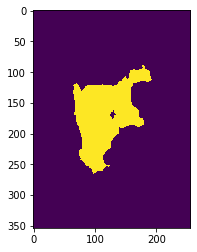

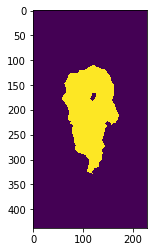

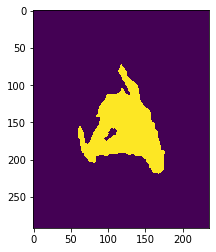

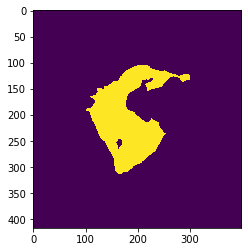

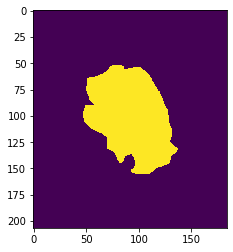

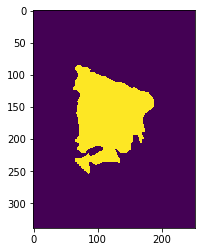

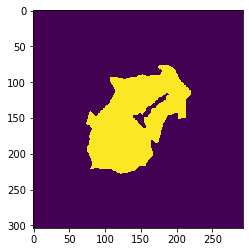

(81542, 5)

In [25]:
def _get_pixels(self, color):
    """
    Use outer annotation with defined color and removed holes to 
    extract features in pixels.
    """
    outer_ids, holes_ids = self.anim.select_just_outer_annotations(color)
    views = self.anim.get_views(outer_ids, level=self.level)
    pixels_list = []
    for id1, id2, view_ann in zip(outer_ids, holes_ids, views):
        ann_raster = view_ann.get_annotation_raster(id1, holes_ids=id2)
#     ann_raster1 = view_ann.get_annotation_region_raster(id1)
#     if len(id2) == 0:
#         ann_raster = ann_raster1
#     else:
#         ann_raster2 = view_ann.get_annotation_region_raster(id2[0])
#         ann_raster = ann_raster1 ^ ann_raster2

        plt.figure()
        plt.imshow(ann_raster)
        plt.show()
        img = self._get_features(view_ann)
        pixels = img[ann_raster]
        pixels_list.append(pixels)
    pixels_all = np.concatenate(pixels_list, axis=0)

    return pixels_all
pixels_all = _get_pixels(seg, "#000000")
pixels_all.shape


In [8]:
type(ann_raster)

numpy.ndarray

# Training

In [41]:
seg.train_svm_classifier()
seg.save_classifier()

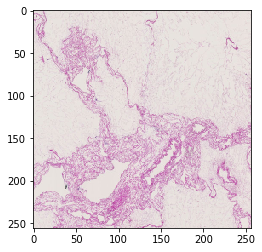

In [12]:
seg.make_tiles()
img = seg.tiles[2][2].get_region_image()
plt.imshow(img)

In [ ]:
fts = seg

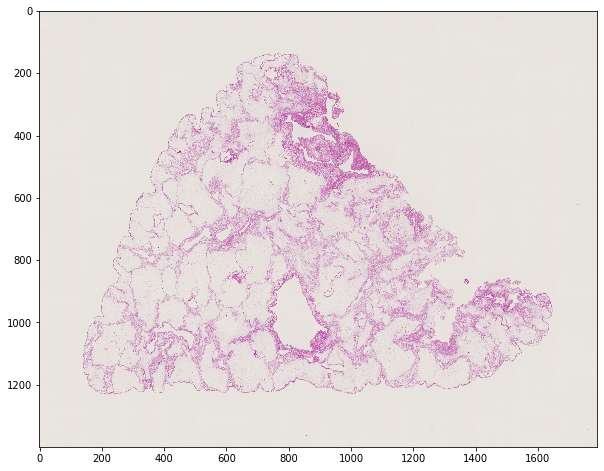

In [53]:
plt.imshow(seg.get_raster_image())

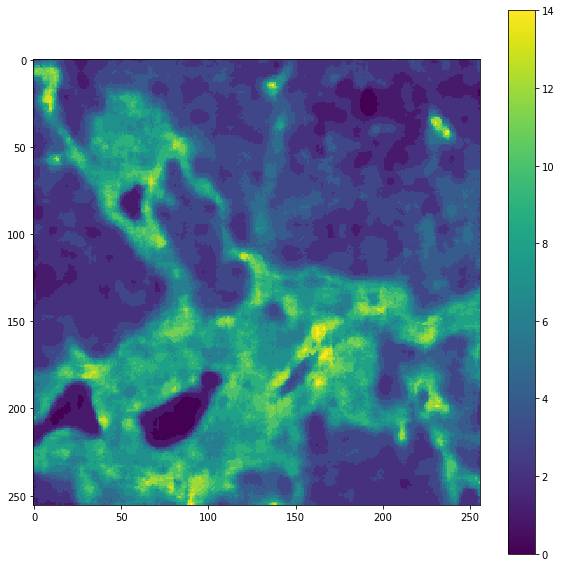

In [49]:

pred = seg._get_features(seg.tiles[2][2])
plt.figure(figsize(10,10))
plt.imshow(pred[:,:,7])
plt.colorbar()

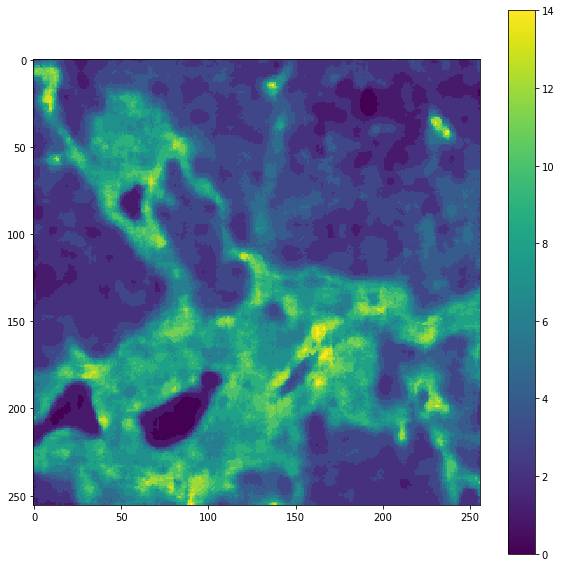

In [28]:

import skimage.filters
from skimage.morphology import disk
pred = seg._get_features(seg.tiles[2][2])

img_sob = skimage.filters.sobel(pred[:,:,0]/255)

img_sob = skimage.filters.median(img_sob, disk(5) )
# img_sob = gaussian_filter(skimage.filters.sobel(pred[:,:,0]), 2)
plt.figure(figsize(10,10))
plt.imshow(img_sob)
plt.colorbar()

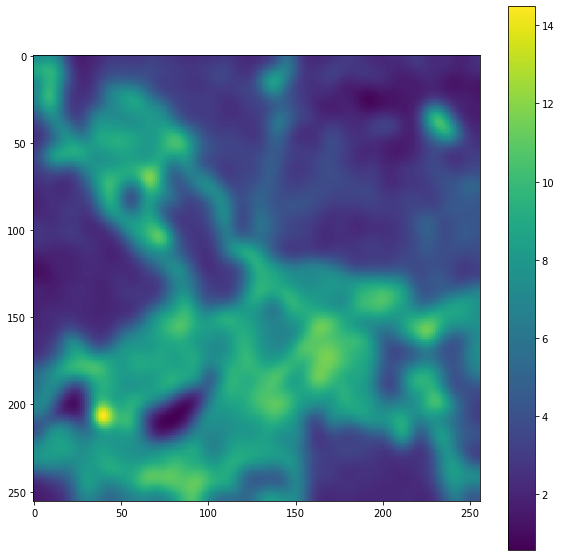

In [29]:
pred = seg._get_features(seg.tiles[2][2])

# img_sob = skimage.filters.sobel(pred[:,:,0]/255)

# img_sob = skimage.filters.median(img_sob, disk(5) )
img_sob = gaussian_filter(skimage.filters.sobel(pred[:,:,0]), 5)
plt.figure(figsize(10,10))
plt.imshow(img_sob)
plt.colorbar()

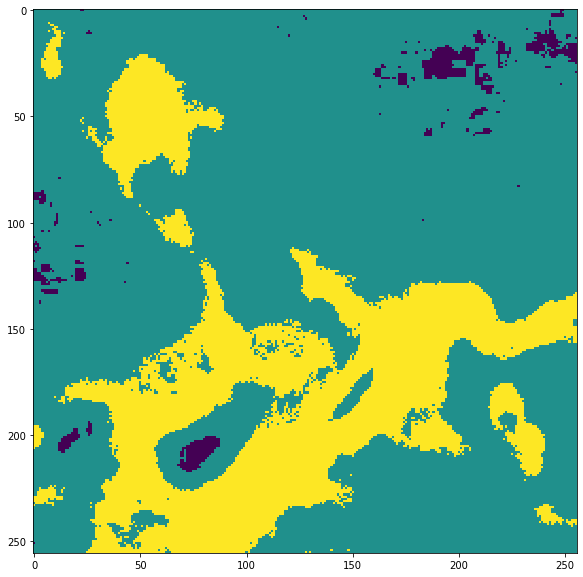

In [50]:
pred = seg.predict_on_view(seg.tiles[2][2])
plt.imshow(pred)

In [484]:
# seg.predict_tiles()

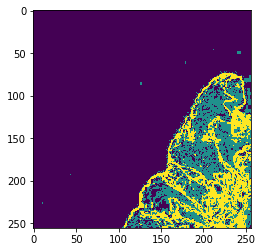

In [485]:
# plt.imshow(seg.predicted_tiles[1][1])

In [39]:
full_image = seg.predict()
seg.full_output_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [2, 2, 2, ..., 2, 2, 2]])

In [251]:
# def predict(self):
# #         if self.predicted_tiles is None:
# #             self.predict_tiles()
        
#         szx = len(self.tiles)
#         szy = len(self.tiles[0])
#         print(f"size x={szx} y={szy}")
        
#         imsize, tile_size_on_level0, tile_size_on_level, imsize_on_level = self._get_tiles_parameters()
#         output_image = np.zeros(self.tile_size * np.asarray([szy, szx]), dtype=int )
#         for iy, tile_column in enumerate(self.tiles):
#             for ix, tile in enumerate(tile_column):
#                 output_image[
#                     ix * self.tile_size[0]: (ix + 1) * self.tile_size[0],
#                     iy * self.tile_size[1]: (iy + 1) * self.tile_size[1]
# #                     int(x0):int(x0 + tile_size_on_level[0]), 
# #                     int(y0):int(y0 + tile_size_on_level[1])    
# #                 ] = self.tiles[ix][iy].get_region_image(as_gray=True)
# #                 ] = self.tiles[iy][ix].get_region_image(as_gray=True)
#                 ] = self.predicted_tiles[iy][ix]
                
#                 pass
#         full_image = output_image[:int(imsize_on_level[1]), :int(imsize_on_level[0])]
#         return full_image
# full_image = predict(seg)

size x=7 y=6


In [52]:
seg.run()

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\

In [81]:
plt.imsave('pokus2.png', seg.full_output_image)

In [60]:
img = seg.get_raster_image()

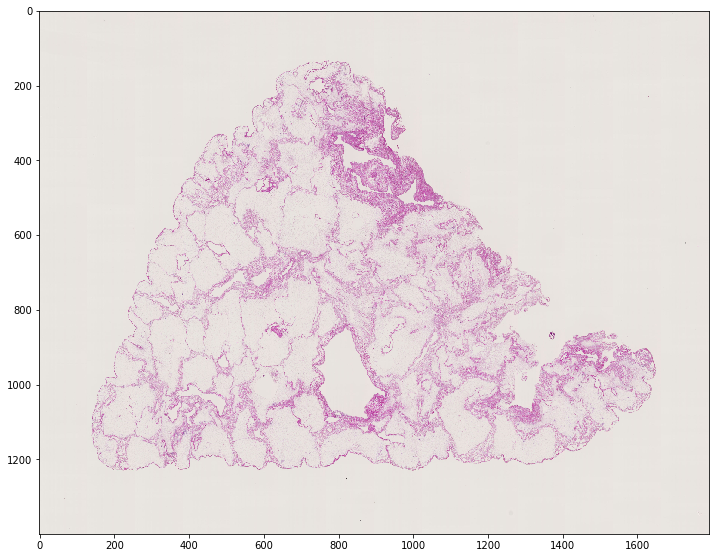

In [61]:

plt.figure(figsize=(12,12))
plt.imshow(
#     seg.full_output_image
    seg.full_raster_image
#     img
#     full_image[500:1000, 500:1000]
)
# plt.colorbar()

In [51]:

plt.figure(figsize=(12,12))
plt.imshow(
    seg.full_prefilter_image
#     seg.full_raster_image
#     img
#     full_image[500:1000, 500:1000]
)
# plt.colorbar()

AttributeError: 'SlideSegmentation' object has no attribute 'full_prefilter_image'

<Figure size 864x864 with 0 Axes>

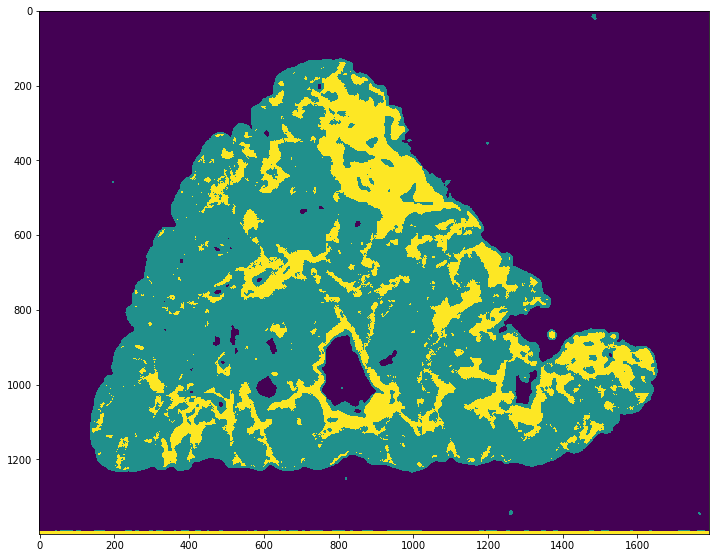

In [53]:

plt.figure(figsize=(12,12))
plt.imshow(
    seg.full_output_image
#     seg.full_raster_image
#     img
#     full_image[500:1000, 500:1000]
)
# plt.colorbar()

In [41]:
window1 = [slice(1000,1500), slice(1000, 1500)]
window2 = [slice(500,1000), slice(500, 1000)]
window3 = [slice(1000,1500), slice(500, 1000)]

# Looking for big enough area

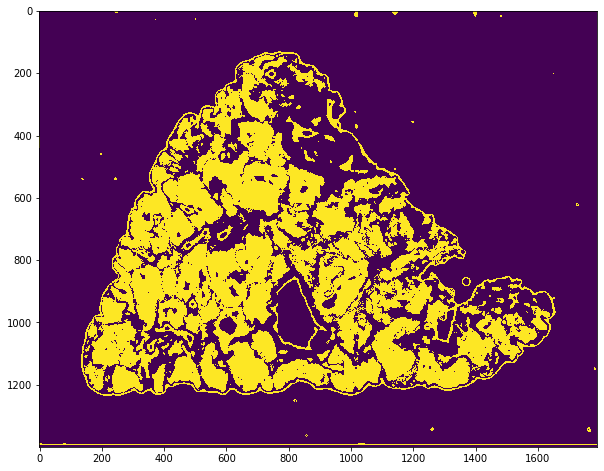

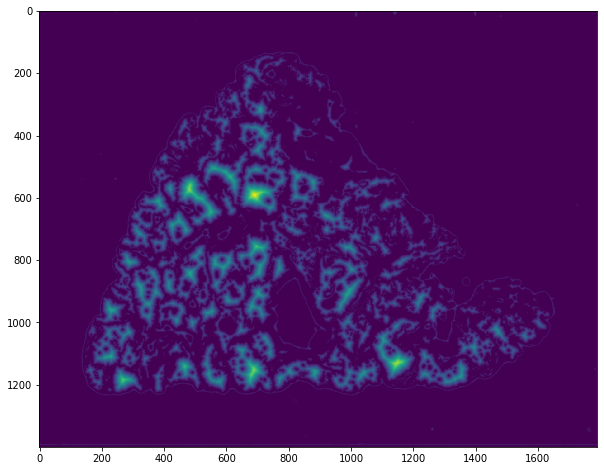

In [44]:
import scipy.ndimage
# dist = scipy.ndimage.morphology.distance_transform_edt(tmp_img != 2)
mask = seg.full_output_image == 1
dist = scipy.ndimage.morphology.distance_transform_edt(mask)
plt.figure(figsize=[10,10])
plt.imshow((mask).astype(np.int))
plt.figure(figsize=[10,10])
plt.imshow(dist)

In [45]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

In [78]:

# plt.figure(figsize=(10,10))
# plt.imshow(dist, cmap=plt.cm.gray)
# plt.autoscale(False)
# plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
# plt.axis('off')
# plt.set_title('Peak local max')


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


(-0.5, 1791.5, 1399.5, -0.5)

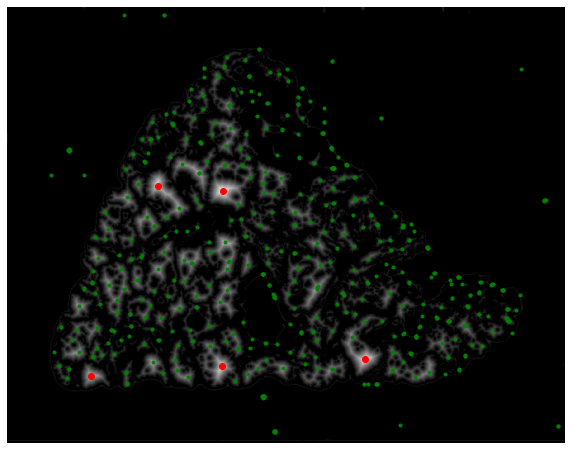

In [81]:
n_max = 5
image_max = ndi.maximum_filter(dist, size=20, mode='constant')
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(dist, min_distance=20)
point_dist = dist[list(zip(*coordinates))] 
# display(point_dist)
max_point_inds = point_dist.argsort()[-n_max:][::-1]
max_points = coordinates[max_point_inds]

plt.figure(figsize=(10,10))
plt.imshow(dist, cmap=plt.cm.gray)
plt.autoscale(False)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'g.')
plt.plot(max_points[:, 1], max_points[:, 0], 'ro')
plt.axis('off')

# something else

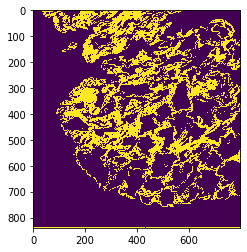

In [119]:
im_cr = seg.full_output_image[1000:1900, 200:1000]
plt.imshow((im_cr==2))
# plt.colorbar()

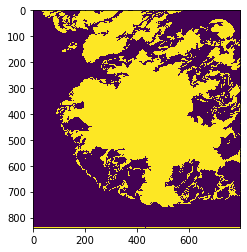

In [120]:
filled = scipy.ndimage.morphology.binary_fill_holes(im_cr==2)
plt.imshow(filled)

## Label filtration

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq

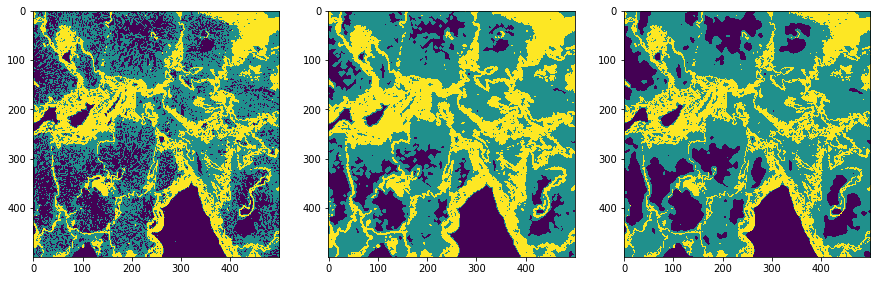

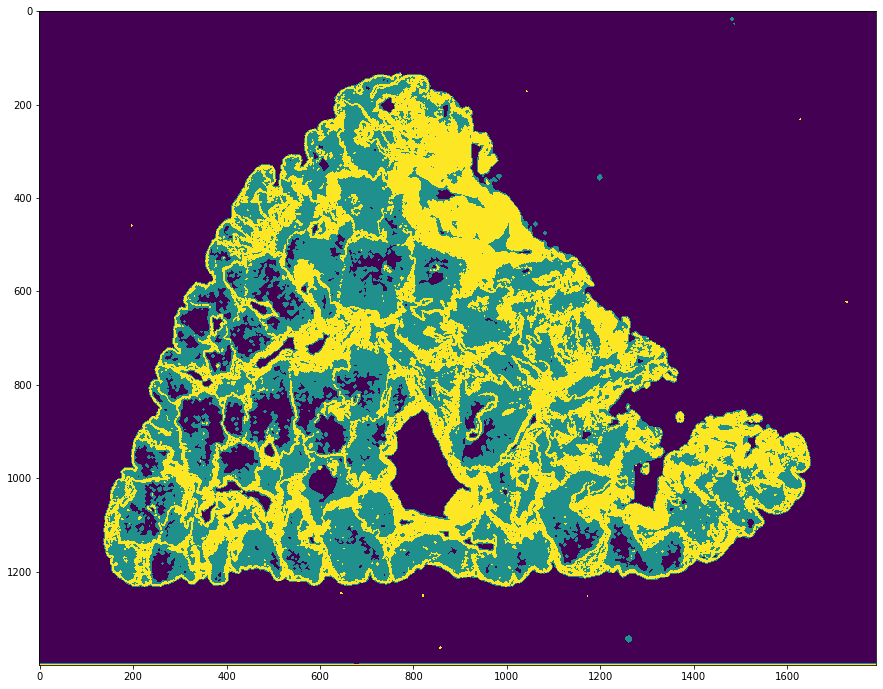

In [197]:

def _labeling_filtration(self, full_image):
    """
    smooth label 0 and label 1, keep label 2
    """
    tmp_img = full_image.copy()
    tmp_img[full_image == 2] = 1
    import skimage.filters
    tmp_img = skimage.filters.gaussian(tmp_img.astype(np.float), sigma=2)

    tmp_img = (tmp_img > 0.5).astype(np.int)
    tmp_img[full_image == 2] = 2
    return tmp_img

imf = _labeling_filtration(seg, seg.full_prefilter_image)
# remove small internal holes in ligament
ligament = scipy.ndimage.morphology.binary_dilation(imf==2, iterations=1)
label = seg.full_output_image.copy()
# remove small holes in intralobular area
intralobular = scipy.ndimage.morphology.binary_dilation(imf==1, iterations=2)
label[intralobular] = 1
label[ligament] = 2

window = window2

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(seg.full_prefilter_image[window])
plt.subplot(132)
plt.imshow(label[window])
plt.subplot(133)
plt.imshow(seg.full_output_image[window])
plt.figure(figsize=(15,15))
plt.imshow(label)

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


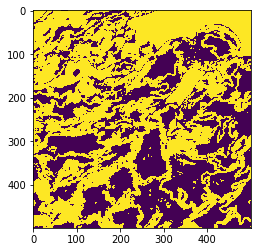

In [144]:
plt.imshow((label[window3]!=1))

In [88]:
dist_cr = dist[500:1000, 500:1000]

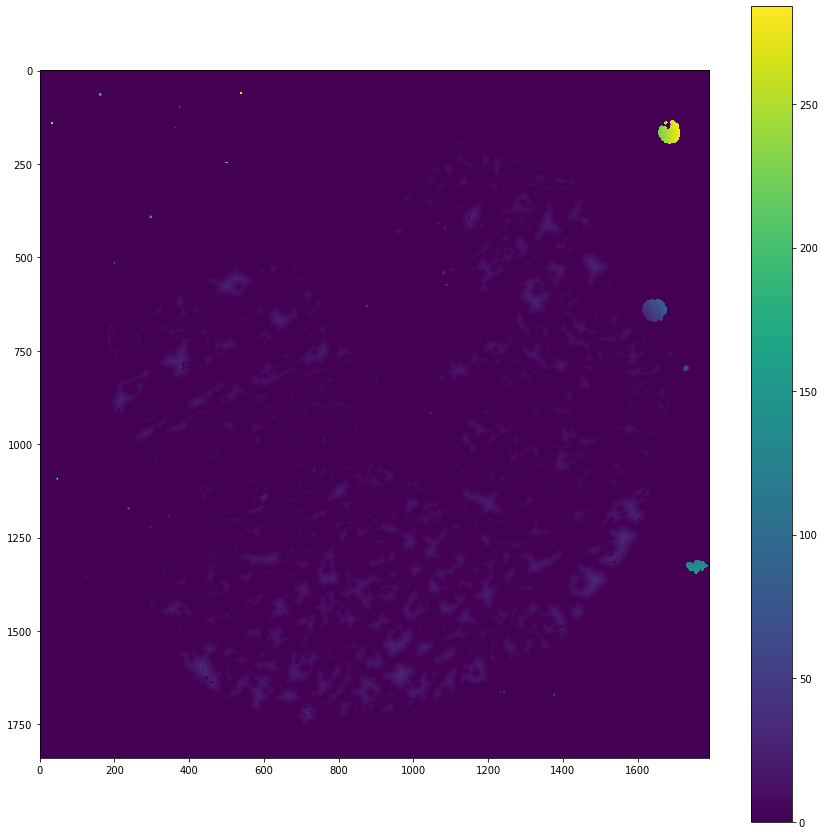

In [168]:
plt.figure(figsize=(15,15))
plt.imshow(scipy.ndimage.morphology.distance_transform_edt(label!=2) * (label == 1).astype(np.int))
plt.colorbar()

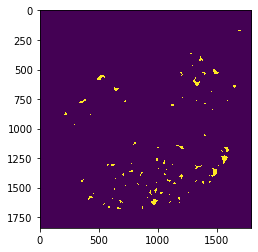

In [165]:
plt.imshow(dist > 15)

In [292]:
tmp_img > 0.5

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False]])

In [257]:
_, count = np.unique(full_image, return_counts=True)

intralobular_ratio = count[2] / (count[1] + count[2])

intralobular_ratio

0.35995119921974683

In [110]:
seg.predicted_tiles[41]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [245]:
full_image

In [ ]:
seg

# Gradient operators

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.


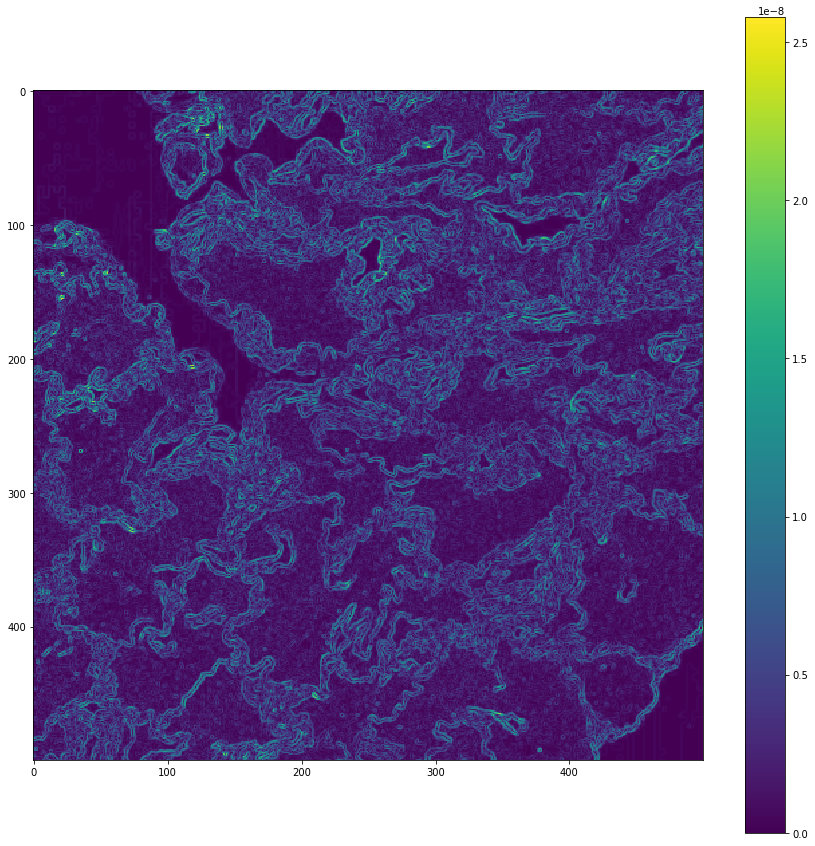

In [177]:
import skimage.filters
sob = skimage.filters.sobel(seg.full_raster_image[:,:,0])
plt.figure(figsize=(15, 15))
plt.imshow(sob[window1])
plt.colorbar()

# Other clasifiers

In [37]:
X, y = seg.prepare_training_pixels()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.98, random_state=42)
X_train.shape

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(3357, 8)

In [36]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(),
]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
#          "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "QDA",
         "Naive Bayes", 
        ]

fit Nearest Neighbors
fit done: Nearest Neighbors
score Nearest Neighbors: 0.9673447309723648


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


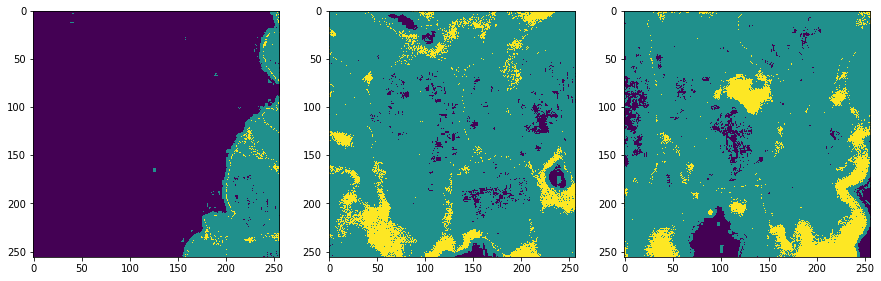

fit Linear SVM
fit done: Linear SVM
score Linear SVM: 0.9670833915775783


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


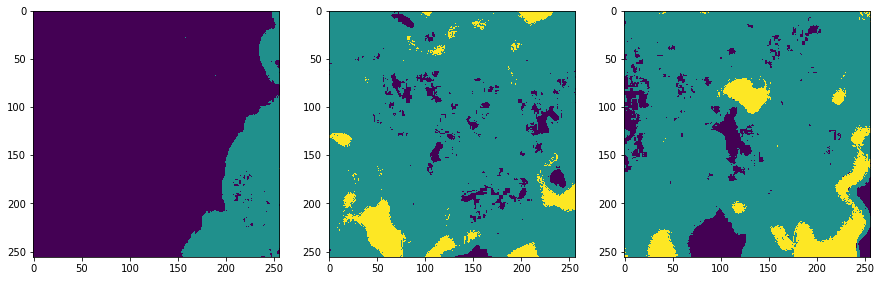

fit RBF SVM
fit done: RBF SVM
score RBF SVM: 0.6874259285145591


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


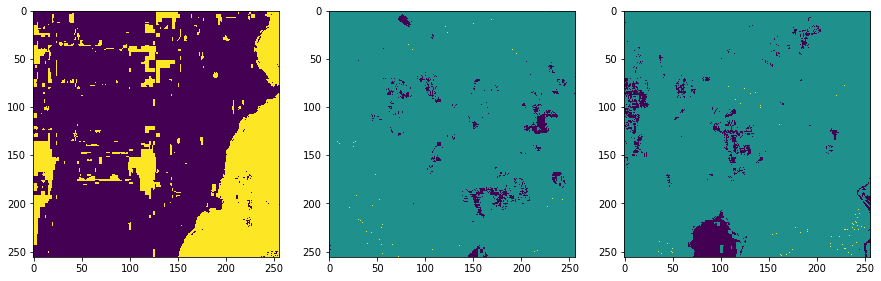

fit Decision Tree
fit done: Decision Tree
score Decision Tree: 0.979493973999769


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


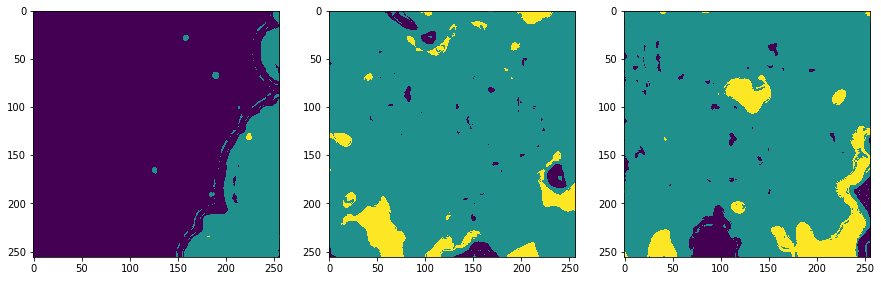

fit Random Forest
fit done: Random Forest
score Random Forest: 0.9761087171882312


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


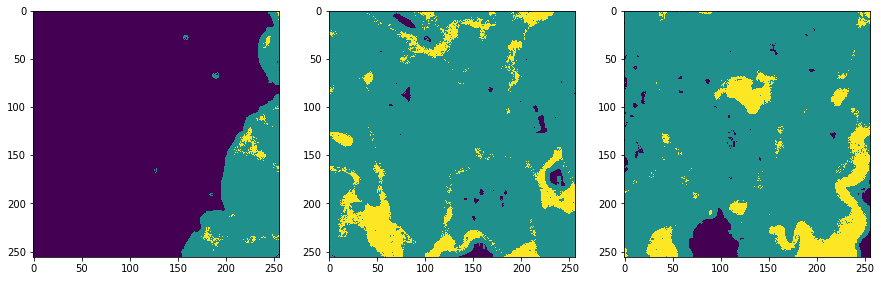

fit Neural Net
fit done: Neural Net
score Neural Net: 0.9449303196241575


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


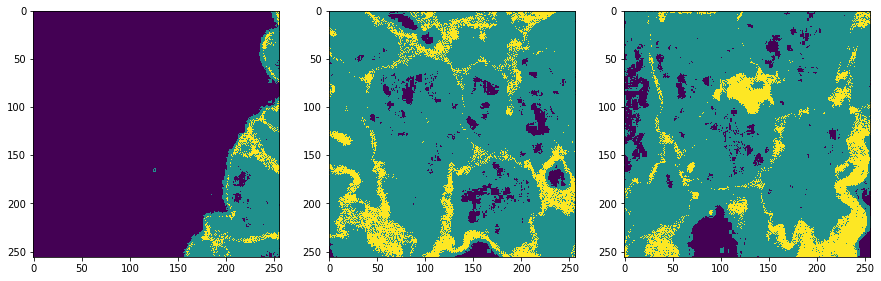

fit AdaBoost
fit done: AdaBoost
score AdaBoost: 0.9729787221111361


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


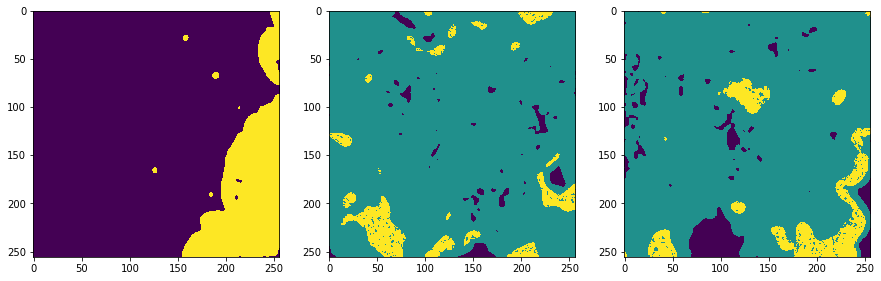

fit QDA
fit done: QDA
score QDA: 0.9643059008004279


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


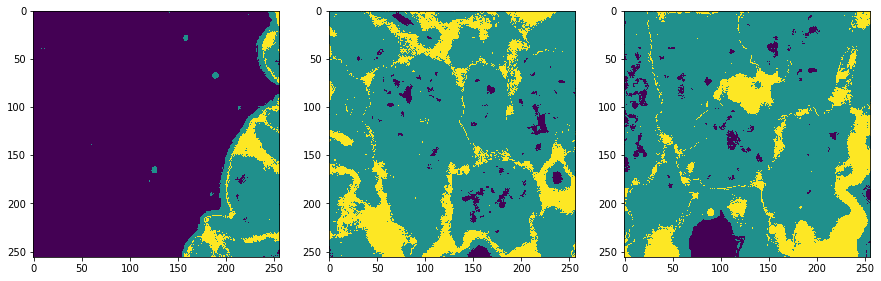

fit Naive Bayes
fit done: Naive Bayes
score Naive Bayes: 0.9510687565714703


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


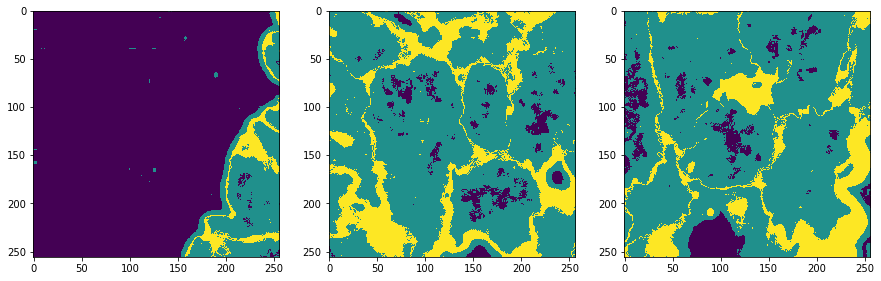

In [38]:
for name, clf in zip(names, classifiers):
#         ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    print(f"fit {name}")
    clf.fit(X_train, y_train)
    print(f"fit done: {name}")
    score = clf.score(X_test, y_test)
    print(f"score {name}: {score}")
    seg.clf = clf
    plt.figure(figsize=(15,10))
    plt.subplot(131)    
    pred = seg.predict_on_view(seg.tiles[0][3])
    plt.imshow(pred)
    plt.subplot(132)    
    pred = seg.predict_on_view(seg.tiles[1][3])
    plt.imshow(pred)
    plt.subplot(133)    
    pred = seg.predict_on_view(seg.tiles[2][3])
    plt.imshow(pred)
    plt.show()
    

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Jirik\

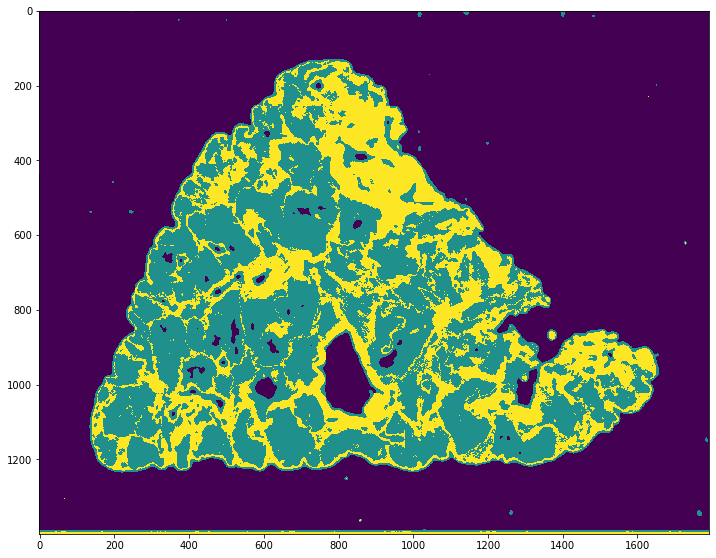

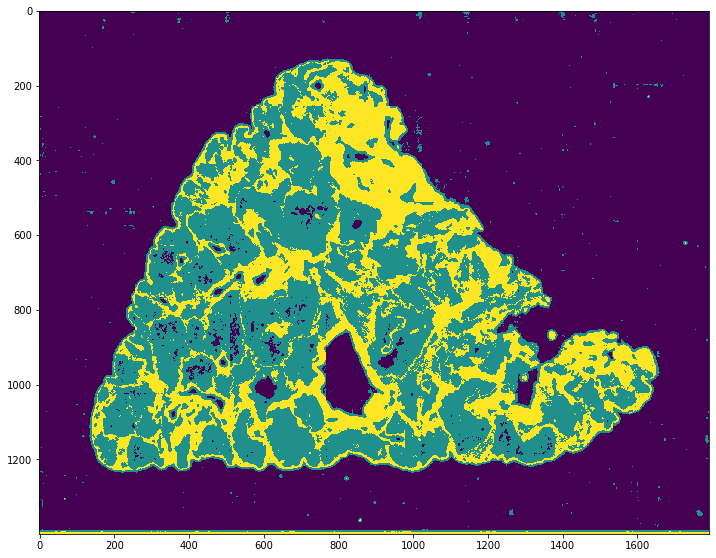

In [40]:
seg.run()

plt.figure(figsize=(12,12))
plt.imshow(
    seg.full_output_image
#     seg.full_raster_image
#     img
#     full_image[500:1000, 500:1000]
)
plt.figure(figsize=(12,12))
plt.imshow(
    seg.full_prefilter_image
#     seg.full_raster_image
#     img
#     full_image[500:1000, 500:1000]
)